# **Normalized Convolution**

In this notebook we will explore the Normalized Convolution as described in section 3 of this [paper](http://liu.diva-portal.org/smash/get/diva2:302485/FULLTEXT01.pdf). Efficent implementation of the approach was inspired by this repository: https://github.com/ericPrince/optical-flow

In [2]:
import scipy
import numpy as np
import cv2
from skimage.data import astronaut
import matplotlib.pyplot as plt
%matplotlib inline

##### Get the test image

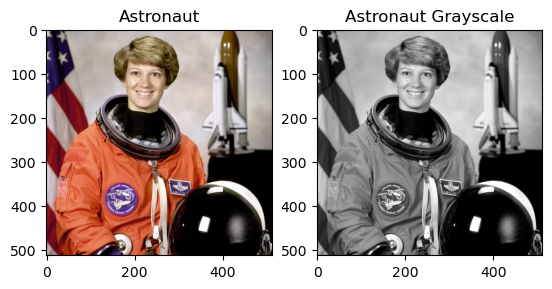

In [3]:
image_rgb = astronaut()
image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

plt.subplot(121)
plt.imshow(image_rgb)
plt.title("Astronaut");

plt.subplot(122)
plt.imshow(image, cmap='gray')
plt.title("Astronaut Grayscale");

#### Next we will randomly sample a percentage of pixels in the image to simulate a degraded image. The portion of pixels to randonly sample is denoted by $\alpha$.

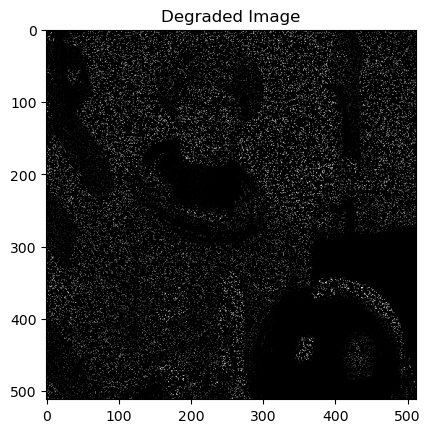

In [4]:
alpha = 0.1 # probability of selecting a pixel
rng = np.random.default_rng()
mask = rng.choice([0,1], size=image.shape, p=[1 - alpha, alpha])

degraded_image = image.copy()
degraded_image[mask == 0] = 0

plt.imshow(degraded_image, cmap='gray')
plt.title("Degraded Image");

### Now let's implement a Regular Smoothing Convolution to restore this image

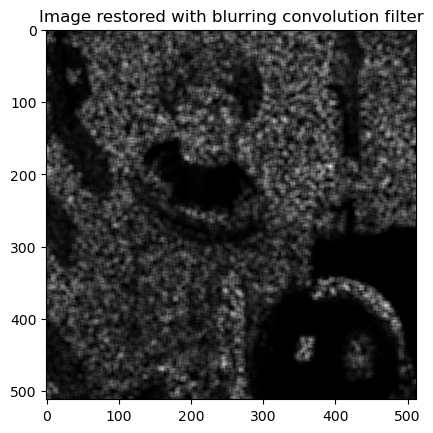

In [6]:
# Apply blurring kernel
kernel = np.ones((7, 7), np.float32) / 25
restore_conv = cv2.filter2D(src=degraded_image, ddepth=-1, kernel=kernel)

plt.imshow(restore_conv, cmap='gray')
plt.title("Image restored with blurring convolution filter");

Using a regular convolution does not work very well. This is because no compensation is made for the variation in local sampling density.


### Now let's implement Normalized Convolution

In [169]:
def normalized_convolution(f: np.ndarray, c: np.ndarray, a: np.ndarray,
                           bx: np.ndarray, by: np.ndarray)-> np.ndarray:
    """ Computes Normalized Convolution and returns the coefficients r as well as 
        The polynomial basis functions in the x and y dimensions. For the efficieny,
        the computations are implemented as separable convolutions. 

        Inputs: 
            f  - signal
            c  - signal certainty (same shape as the signal)
            a  - (nxn) applicability kernel for each pixel
            bx - x-dimension basis functions of predefined polynomial order
            by - y-dimension basis functions of predefined polynomial order

        Outputs
            r - Computed Coefficients --> parameterization for input polynomial basis functions
            
        References:
            [1]    G. Farneback, “Polynomial Expansion for Orientation and Motion Estimation,” 
            Ph.D. dissertation, Inst. of  Technology, Linköping Univ., Norrköping, Sweden, 2002. 
            [Online]. Available: http://liu.diva-portal.org/smash/get/diva2:302485/FULLTEXT01.pdf
            (Chapter 3)
        """
    # get dimensionality of applicability
    n = a.shape[0]

    # reshape applicability kernel
    a = a.reshape(-1)

    # Pre-calculate product of certainty and signal
    cf = c * f

    # G and v are used to calculate "r" from the paper: v = G*r
    # r is the parametrization of the 2nd order polynomial for f
    G = np.empty(list(f.shape) + [bx.shape[-1]] * 2)
    v = np.empty(list(f.shape) + [bx.shape[-1]])

    # Apply separable cross-correlations

    # Pre-calculate quantities recommended in paper
    ab_x = np.einsum("i,ij->ij", a, bx)
    abb_x = np.einsum("ij,ik->ijk", ab_x, bx)

    # Calculate G and v for each pixel with cross-correlation
    for i in range(bx.shape[-1]):
        for j in range(bx.shape[-1]):
            G[..., i, j] = scipy.ndimage.correlate1d(
                c, abb_x[..., i, j], axis=0, mode="constant", cval=0
            )

        v[..., i] = scipy.ndimage.correlate1d(
            cf, ab_x[..., i], axis=0, mode="constant", cval=0
        )

    
    # Pre-calculate quantities recommended in paper
    ab_y = np.einsum("i,ij->ij", a, by)
    abb_y = np.einsum("ij,ik->ijk", ab_y, by)

    # Calculate G and v for each pixel with cross-correlation
    # Note that these are of the form x = x*b or x *= b
    # We have already included the c and cf terms in the x-dim computation
    for i in range(by.shape[-1]):
        for j in range(by.shape[-1]):
            G[..., i, j] = scipy.ndimage.correlate1d(
                G[..., i, j], abb_y[..., i, j], axis=1, mode="constant", cval=0
            )

        v[..., i] = scipy.ndimage.correlate1d(
            v[..., i], ab_y[..., i], axis=1, mode="constant", cval=0
        )

    # if G is singular, then we will need to reduce the singularity 
    if np.any(~np.isfinite(np.linalg.cond(G))):
        print("Warning! Singular Matrix! Adding perturbation!")
        # add a small Normal perturbation to reduce singularity of G
        G += np.random.normal(loc=0, scale=0.001, size=G.shape)

    # Solve r for each pixel
    r = np.linalg.solve(G + np.random.normal(loc=0, scale=0.001, size=G.shape), v)

    return r

In [10]:
# get applicability
a = np.array([
    [1, 1, 2, 1, 1],
    [1, 2, 4, 2, 1],
    [2, 4, 7, 4, 2],
    [1, 2, 4, 2, 1],
    [1, 1, 2, 1, 1]
])


# get basis x-dim and y-dim functions for: {1, x, y, x2, xy, y2}
n = a.shape[0]
b = np.repeat(np.c_[np.arange(-(n-1)//2, (n+1)//2)], 
                n, axis=-1).T

# x dimension (set y=1)
bx = np.vstack((
    np.ones((n**2)),    # 1
    b.T.reshape(-1),    # x
    np.ones((n**2)),    # y
    b.T.reshape(-1)**2, # x^2
    b.T.reshape(-1),    # xy
    np.ones((n**2)),    # y^2
)).T

# y dimension (set x=1)
by = np.vstack((
    np.ones((n**2)),  # 1
    np.ones((n**2)),  # x
    b.reshape(-1),    # y
    np.ones((n**2)),  # x^2
    b.reshape(-1),    # xy
    b.reshape(-1)**2, # y^2
)).T


r = normalized_convolution(degraded_image, mask, a, bx, by)

In [9]:
# possible delete    
def get_restored_image(r, bx, by):
    """ Obtains restored image from Normalized Convolution
        Inputs:
            bx - x-dimension basis functions of predefined polynomial order
            by - y-dimension basis functions of predefined polynomial order 
            shape - shape of original image
        """
    fx = np.zeros(r.shape).astype(np.float64)
    fy = np.zeros(r.shape).astype(np.float64)

    for i in range(bx.shape[1]):
        fx[..., i] = scipy.ndimage.correlate1d(
                    r[..., i], np.float64(bx[:, i]), axis=0, mode="constant", cval=0
                )

    # axis = 0 for y axis?
    for i in range(by.shape[1]):
        fy[..., i] = scipy.ndimage.correlate1d(
                    r[..., i], by[:, i], axis=1, mode="constant", cval=0
                )
        
    return fx, fy

Plot the result of the Normalized Convolution. We will only plot the DC Basis function. Note that the higher level Basis functions contain image gradients that provide useful information for possiblt further reconstruction.

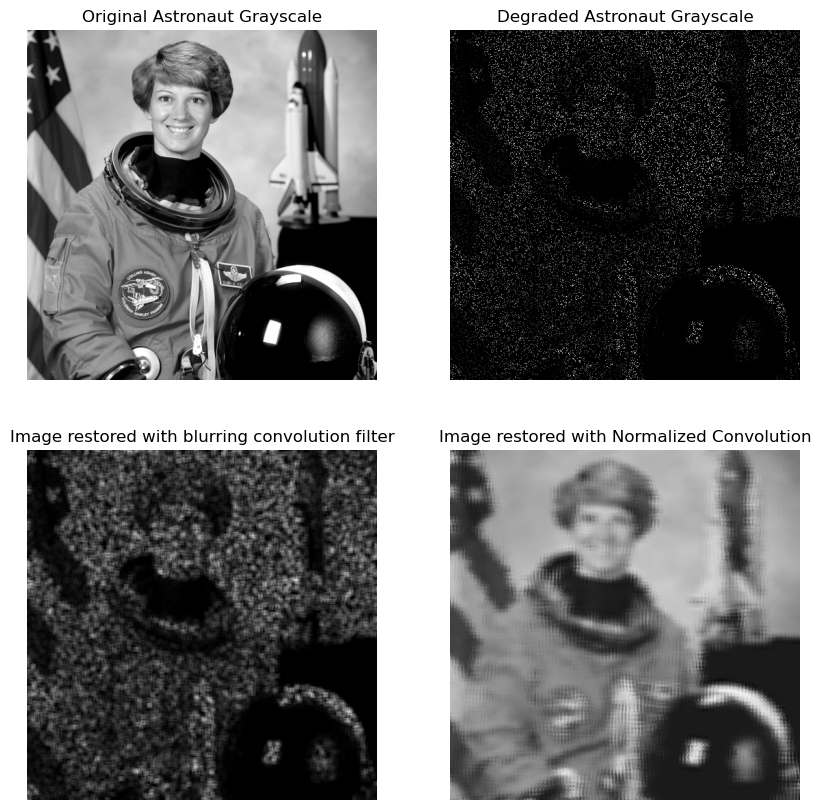

In [18]:
nc_result_1 = cv2.normalize(r[:, :, 0], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(image, cmap='gray')
plt.title("Original Astronaut Grayscale");
plt.axis(False)

plt.subplot(222)
plt.imshow(degraded_image, cmap='gray')
plt.title("Degraded Astronaut Grayscale");
plt.axis(False)

plt.subplot(223)
plt.imshow(restore_conv, cmap='gray')
plt.title("Image restored with blurring convolution filter");
plt.axis(False)

plt.subplot(224)
plt.imshow(nc_result_1, cmap='gray')
plt.title("Image restored with Normalized Convolution");
plt.axis(False);

Let's try a different Applicability kernel

In [130]:
# afun = np.vectorize(lambda x: 0.5*x**(-3) if ((abs(x) > 1) and (abs(x) < 8)) else 1)
afun = np.vectorize(lambda x, sig=1.2: (1/(sig*2*np.pi))*np.exp((-x**2)/(2*sig))) # Gaussian Kernel

def cart_to_pol(x, y, x_c = 0, y_c = 0, deg = True):
    complex_format = x - x_c + 1j * (y - y_c)
    return np.abs(complex_format), np.angle(complex_format, deg = deg)

In [159]:
n = 5
x, y = np.mgrid[-(n-1)//2:(n+1)//2, -(n-1)//2:(n+1)//2]
rho, theta = cart_to_pol(x, y, x_c = 0, y_c = 0, deg = True)

Text(0.5, 1.0, 'Applicability Kernel')

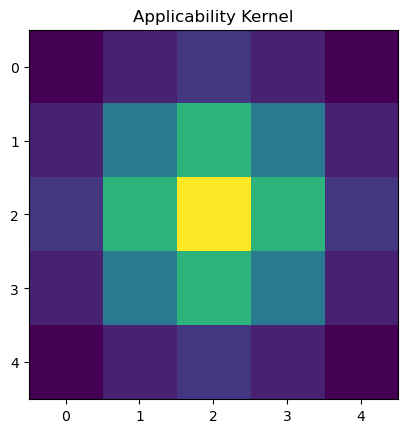

In [160]:
plt.imshow(afun(rho, sig=1.2))
plt.title("Applicability Kernel")

In [164]:
cv2.normalize(afun(rho), None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

array([[  0,  23,  41,  23,   0],
       [ 23, 105, 165, 105,  23],
       [ 41, 165, 255, 165,  41],
       [ 23, 105, 165, 105,  23],
       [  0,  23,  41,  23,   0]], dtype=uint8)

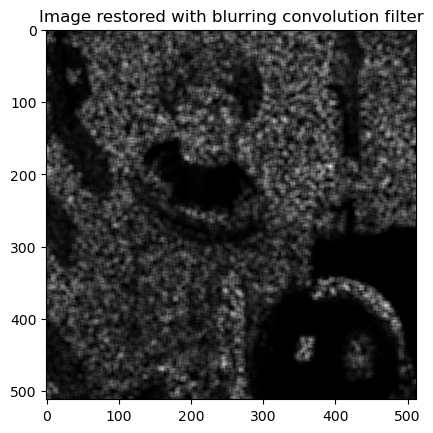

In [165]:

applicability = cv2.normalize(afun(rho), None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
applicability[applicability == 0] = 1 # ensure there are no zeros
restored = cv2.filter2D(src=degraded_image, ddepth=-1, kernel=applicability)
restored = cv2.normalize(restored, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

plt.imshow(restore_conv, cmap='gray')
plt.title("Image restored with blurring convolution filter");

##### Try this again!

In [166]:
b = np.repeat(np.c_[np.arange(-(n-1)//2, (n+1)//2)], 
               n, axis=-1).T

# x dimension (set y=1)
bx = np.vstack((
    np.ones((n**2)),    # 1
    b.T.reshape(-1),    # x
    np.ones((n**2)),    # y
    b.T.reshape(-1)**2, # x^2
    b.T.reshape(-1),    # xy
    np.ones((n**2)),    # y^2
)).T

# y dimension (set x=1)
by = np.vstack((
    np.ones((n**2)),  # 1
    np.ones((n**2)),  # x
    b.reshape(-1),    # y
    np.ones((n**2)),  # x^2
    b.reshape(-1),    # xy
    b.reshape(-1)**2, # y^2
)).T

In [167]:
x, y = np.mgrid[-(n-1)//2:(n+1)//2, -(n-1)//2:(n+1)//2]
rho, theta = cart_to_pol(x, y, x_c = 0, y_c = 0, deg = True)
applicability = cv2.normalize(afun(rho)+1, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)


In [170]:
r = normalized_convolution(degraded_image, mask, applicability, 
                           bx, 
                           by)

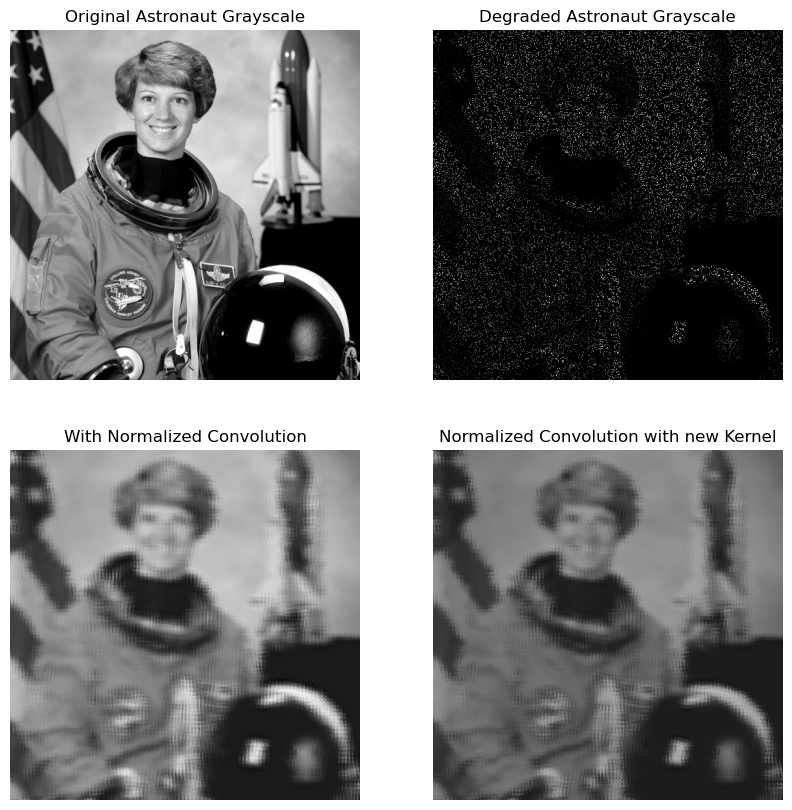

In [171]:
nc_result_2 = cv2.normalize(r[:, :, 0], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(image, cmap='gray')
plt.title("Original Astronaut Grayscale");
plt.axis(False)

plt.subplot(222)
plt.imshow(degraded_image, cmap='gray')
plt.title("Degraded Astronaut Grayscale");
plt.axis(False)

plt.subplot(223)
plt.imshow(nc_result_1, cmap='gray')
plt.title("With Normalized Convolution");
plt.axis(False)

plt.subplot(224)
plt.imshow(nc_result_2, cmap='gray')
plt.title("Normalized Convolution with new Kernel");
plt.axis(False);

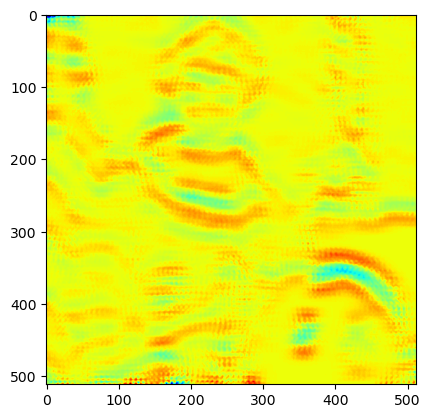

In [83]:
plt.imshow(
    cv2.normalize(r[:, :, 3], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U),
    cmap='jet')


$ r = (B^* W_a W_c B)^{-1} B^* W_a W_c f $

### Reconstruct the signal with
$ \hat{f} = Br $

 [1]    G. Farneback, “Polynomial Expansion for Orientation and Motion Estimation,” Ph.D. dissertation, Inst. of Technology, Linköping Univ., Norrköping, Sweden, 2002. [Online]. Available: http://liu.diva-portal.org/smash/get/diva2:302485/FULLTEXT01.pdf